In [1]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torch.optim as optim

from tqdm import tqdm
import random
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score
from PIL import Image
import pickle

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [3]:
model = models.resnet18(pretrained=True)

num_classes = 3
model.fc = nn.Linear(model.fc.in_features, num_classes)

C:\Users\KIRIL\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\KIRIL\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
import pickle
import os
import numpy as np
import torch

def load_spectrograms(data_dir):
    spectrograms = []
    labels = []
    
    for class_idx, class_name in enumerate(os.listdir(data_dir)):
        class_dir = os.path.join(data_dir, class_name)
        for file in os.listdir(class_dir):
            with open(os.path.join(class_dir, file), 'rb') as f:
                data = pickle.load(f)
            spectrograms.append(data)
            labels.append(class_idx)
    
    return np.array(spectrograms), np.array(labels)

data_dir = 'data/norm/'
X, y = load_spectrograms(data_dir)

In [10]:
X_tensor = torch.from_numpy(X).float()
y_tensor = torch.from_numpy(y).long() 

X_tensor = X_tensor.unsqueeze(1)

(420, 64, 94)

In [21]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_tensor.numpy(), y_tensor.numpy(), 
    test_size=0.2, 
    random_state=42,
    stratify=y_tensor.numpy()
)
X_train = torch.from_numpy(X_train).float()
X_test = torch.from_numpy(X_test).float()
y_train = torch.from_numpy(y_train).long()
y_test = torch.from_numpy(y_test).long()

In [22]:
X_train

tensor([[[[1.7391e-11, 1.3000e-15, 6.2171e-16,  ..., 2.9016e-17,
           6.8508e-17, 8.9218e-16],
          [1.8979e-07, 8.6530e-16, 9.3419e-15,  ..., 3.0731e-14,
           2.1258e-14, 1.0103e-15],
          [3.1435e-08, 1.3739e-14, 1.5373e-15,  ..., 7.2431e-14,
           6.1339e-14, 1.1018e-14],
          ...,
          [3.2266e-12, 1.2614e-15, 3.7603e-14,  ..., 6.6942e-14,
           7.1117e-14, 1.1165e-13],
          [4.3381e-12, 1.5524e-14, 3.4022e-14,  ..., 4.4944e-14,
           2.0748e-14, 4.0819e-14],
          [5.5354e-13, 8.6154e-15, 3.3311e-14,  ..., 8.7088e-15,
           9.5360e-15, 7.8568e-16]]],


        [[[3.6252e-11, 3.7945e-16, 2.6162e-14,  ..., 2.2945e-17,
           1.9334e-16, 2.1987e-15],
          [1.4058e-11, 1.1823e-14, 2.9654e-12,  ..., 4.0409e-14,
           1.7047e-14, 2.8809e-14],
          [1.2705e-11, 1.8140e-15, 3.4817e-12,  ..., 3.3919e-14,
           1.0056e-14, 1.1268e-14],
          ...,
          [2.2696e-14, 3.9695e-14, 2.8553e-15,  ..., 1.46

In [7]:
from torch.utils.data import TensorDataset, DataLoader
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
batch_size = 64
shuffle = True


train_loader = DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    shuffle=shuffle,
    num_workers=4 
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=batch_size, 
    shuffle=False
)

NameError: name 'X_train' is not defined

NameError: name 'train_dataset' is not defined

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet18
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pickle
import os
from sklearn.model_selection import train_test_split

def load_data(data_dir):
    spectrograms = []
    labels = []
    class_names = sorted(os.listdir(data_dir))
    
    for class_idx, class_name in enumerate(class_names):
        class_dir = os.path.join(data_dir, class_name)
        for pkl_file in os.listdir(class_dir):
            if pkl_file.endswith('.pkl'):
                with open(os.path.join(class_dir, pkl_file), 'rb') as f:
                    spec = pickle.load(f)
                spectrograms.append(spec)
                labels.append(class_idx)
    
    return np.array(spectrograms), np.array(labels), class_names







class ResNetSpectrogram(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.resnet = resnet18(pretrained=False)
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=1, padding=0, bias=False)
        self.resnet.avgpool = nn.Identity()
        self.resnet.fc = nn.Identity()
        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)
    
    def forward(self, x):
        
        x = self.resnet.conv1(x)
        x = self.resnet.bn1(x)
        x = self.resnet.relu(x)
        x = self.resnet.maxpool(x)
        #print(x.shape)
        
        x = self.resnet.layer1(x)
        x = self.resnet.layer2(x)
        x = self.resnet.layer3(x)
        x = self.resnet.layer4(x)
        #print(x.shape)
        
        x = self.adaptive_pool(x)
        #print(x.shape)
        
        x = torch.flatten(x, 1)
        #print(x.shape)

        x = self.fc(x)
        #print(x.shape)
        return x

def prepare_loaders(X, y, test_size=0.2, batch_size=32):
    #X = (X - X.mean()) / X.std()
    X = torch.FloatTensor(X).unsqueeze(1)
    y = torch.LongTensor(y)
    
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=test_size, random_state=42, stratify=y
    )
    
    train_loader = DataLoader(
        TensorDataset(X_train, y_train),
        batch_size=batch_size,
        shuffle=True
    )
    val_loader = DataLoader(
        TensorDataset(X_val, y_val),
        batch_size=batch_size
    )
    return train_loader, val_loader

def train_model(model, train_loader, val_loader, classes, epochs=15, lr=0.0001):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2)
    train_loss_data = [0]
    val_loss_data = [0]
    train_acc_data = [0]
    val_acc_data = [0]
    
    best_acc = 0
    for epoch in range(epochs):
        model.train()
        train_loss, correct = 0, 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()


        model.eval()
        val_loss, val_correct = 0, 0
        all_preds, all_labels = [], []
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                val_loss += criterion(outputs, labels).item()
                
                _, predicted = torch.max(outputs, 1)
                val_correct += (predicted == labels).sum().item()
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        # Метрики
        train_loss /= len(train_loader)
        train_acc = correct / len(train_loader.dataset)
        val_loss /= len(val_loader)
        val_acc = val_correct / len(val_loader.dataset)
        train_loss_data.append(train_loss)
        train_acc_data.append(train_acc)
        val_loss_data.append(val_loss)
        val_acc_data.append(val_acc)
        
        print(f"Epoch {epoch+1}/{epochs}:")
        print(f"Train Loss: {train_loss:.4f} | Acc: {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f} | Acc: {val_acc:.4f}")

        
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), 'best_model.pth')
        
        scheduler.step(val_acc)

    return train_loss_data, train_acc_data, val_loss_data, val_acc_data

if __name__ == "__main__":
    DATA_DIR = "./data/norm/"
    BATCH_SIZE = 20
    EPOCHS = 5
    
    X, y, classes = load_data(DATA_DIR)
    print(f'размер датасета {X.shape[0]}')
    train_loader, val_loader = prepare_loaders(X, y, batch_size=BATCH_SIZE)
    model = ResNetSpectrogram(num_classes=len(classes))
    print(classes)
    print('обучение')
    train_loss, train_acc, val_loss, val_acc = train_model(model, train_loader, val_loader, classes, epochs=EPOCHS)

размер датасета 2404
['алгоритмы', 'время', 'дата', 'шум']
обучение


C:\Users\KIRIL\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\KIRIL\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1/5:
Train Loss: 0.4023 | Acc: 0.8627
Val Loss: 0.1475 | Acc: 0.9522
Epoch 2/5:
Train Loss: 0.0327 | Acc: 0.9943
Val Loss: 0.0479 | Acc: 0.9875
Epoch 3/5:
Train Loss: 0.0258 | Acc: 0.9932
Val Loss: 0.0514 | Acc: 0.9896
Epoch 4/5:
Train Loss: 0.0108 | Acc: 0.9984
Val Loss: 0.0345 | Acc: 0.9938
Epoch 5/5:
Train Loss: 0.0417 | Acc: 0.9979
Val Loss: 0.0478 | Acc: 0.9854


In [2]:
ResNetSpectrogram(4)

ResNetSpectrogram(
  (resnet): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, 

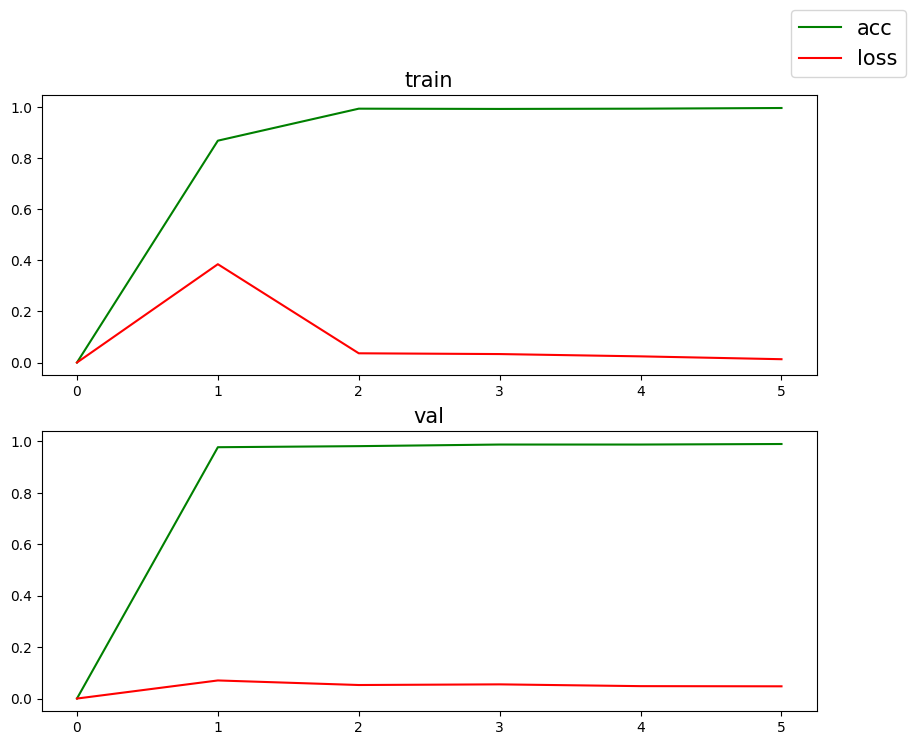

In [3]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2, 1, figsize = (10, 8))
ax[0].set_title('train', fontsize = 15)
ax[0].plot(range(EPOCHS + 1), train_acc, label = 'acc', color = 'green')
ax[0].plot(range(EPOCHS + 1), train_loss, label = 'loss', color = 'red')
ax[1].set_title('val', fontsize = 15)
ax[1].plot(range(EPOCHS + 1), val_acc, color = 'green')
ax[1].plot(range(EPOCHS + 1), val_loss, color = 'red')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('epoch')
fig.legend(fontsize = 15)

torch.Size([257, 71])


C:\Users\KIRIL\AppData\Local\Temp\ipykernel_9564\2727894006.py:11: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  data1 = np.array(X_train[0][0])
C:\Users\KIRIL\AppData\Local\Temp\ipykernel_9564\2727894006.py:14: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  data2 = np.array(X_train[120][0])


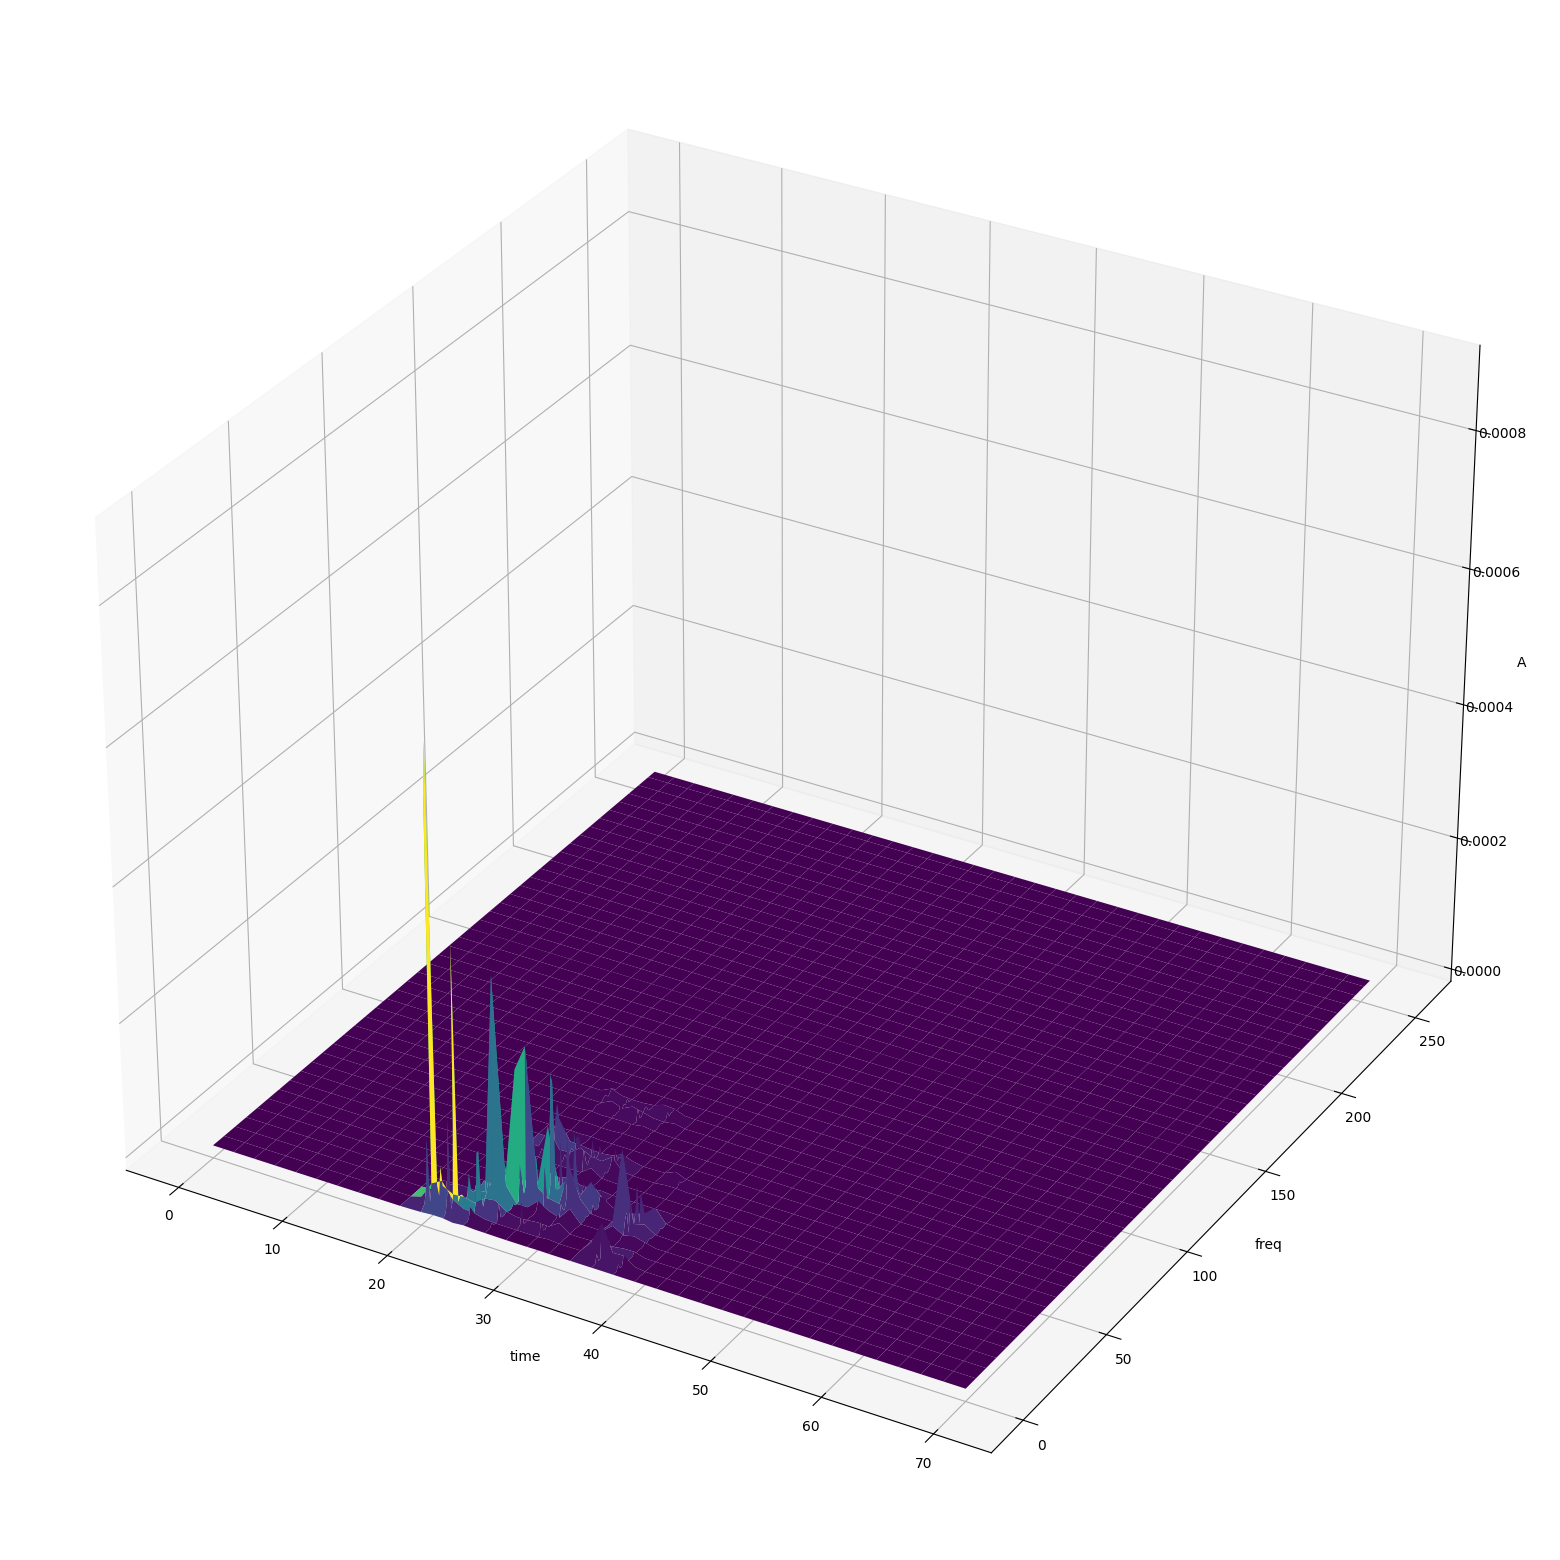

In [89]:

# алгоритмы
import matplotlib.pyplot as plt
print(X_train[0][0].shape)
fig = plt.figure(figsize = (20, 20))
axes = fig.add_subplot(projection = '3d')
axes.set_xlabel('time')
axes.set_ylabel('freq')
axes.set_zlabel('A')



data1 = np.array(X_train[0][0])
times = np.arange(data.shape[1])
freq = np.arange(data.shape[0])
data2 = np.array(X_train[120][0])

X, Y = np.meshgrid(times, freq)

axes.plot_surface(X, Y, data2, cmap = 'viridis')




tensor([[[[1.7391e-11, 1.3000e-15, 6.2171e-16,  ..., 2.9016e-17,
           6.8508e-17, 8.9218e-16],
          [1.8979e-07, 8.6530e-16, 9.3419e-15,  ..., 3.0731e-14,
           2.1258e-14, 1.0103e-15],
          [3.1435e-08, 1.3739e-14, 1.5373e-15,  ..., 7.2431e-14,
           6.1339e-14, 1.1018e-14],
          ...,
          [3.2266e-12, 1.2614e-15, 3.7603e-14,  ..., 6.6942e-14,
           7.1117e-14, 1.1165e-13],
          [4.3381e-12, 1.5524e-14, 3.4022e-14,  ..., 4.4944e-14,
           2.0748e-14, 4.0819e-14],
          [5.5354e-13, 8.6154e-15, 3.3311e-14,  ..., 8.7088e-15,
           9.5360e-15, 7.8568e-16]]],


        [[[3.6252e-11, 3.7945e-16, 2.6162e-14,  ..., 2.2945e-17,
           1.9334e-16, 2.1987e-15],
          [1.4058e-11, 1.1823e-14, 2.9654e-12,  ..., 4.0409e-14,
           1.7047e-14, 2.8809e-14],
          [1.2705e-11, 1.8140e-15, 3.4817e-12,  ..., 3.3919e-14,
           1.0056e-14, 1.1268e-14],
          ...,
          [2.2696e-14, 3.9695e-14, 2.8553e-15,  ..., 1.46

In [111]:
X_train[0].shape

torch.Size([1, 257, 71])

In [4]:
import torchvision
model = torchvision.models.resnet18(pretrained=True)
#model = ResNetSpectrogram(num_classes=len(classes))
print(model)  # Вывод архитектуры

C:\Users\KIRIL\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\KIRIL\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [13]:
from fill_data import *
model.eval()
model(normalize(create_mel_spec(get_signal())))

Запись началась...
Запись завершена!


TypeError: 'int' object is not callable

In [32]:
import matplotlib.pyplot as plt
import librosa
data = X[0]
log_mel = librosa.power_to_db(data, ref=np.max, top_db=70)


array([[-64.24421 , -70.      , -70.      , ..., -70.      , -70.      ,
        -70.      ],
       [-48.658363, -70.      , -70.      , ..., -70.      , -70.      ,
        -70.      ],
       [-56.250076, -70.      , -70.      , ..., -70.      , -70.      ,
        -70.      ],
       ...,
       [-70.      , -70.      , -70.      , ..., -70.      , -70.      ,
        -70.      ],
       [-70.      , -70.      , -70.      , ..., -70.      , -70.      ,
        -70.      ],
       [-70.      , -70.      , -70.      , ..., -70.      , -70.      ,
        -70.      ]], shape=(257, 71), dtype=float32)

In [13]:


model = ResNetSpectrogram(num_classes=4)
model.load_state_dict(torch.load('best_model.pth'))
model.eval()
from fill_data import *
spec = normalize(create_mel_spec(get_signal()))
spec_tensor = torch.FloatTensor(spec).unsqueeze(0).unsqueeze(0)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
input_data = spec_tensor.to(device)
with torch.no_grad():
    outputs = model(input_data)
    _, predicted = torch.max(outputs, 1)
    class_idx = predicted.item()

classes[class_idx]



Запись началась...
Запись завершена!


'алгоритмы'

In [2]:
import os
import pickle
directories = ['./data_to_transform/norm/', './data_to_transform/wo_normalize/', './data_to_transform/raw/']
classes = ['алгоритмы', 'дата', 'время']
k = 0
if True:
    for c in classes:
        for filename in os.listdir(directory + c):
            filepath = os.path.join('./data_to_transform/raw/' + c, filename)
            #print(filepath[:len(directory + c)])
            f = open(filepath, 'rb')
            data = pickle.load(f)
            f.close()
            f = open('./data/' + directory[20:] + c + f'/mk{k}.pkl', 'wb')
            pickle.dump(data, f)
            k += 1
            f.close()
        


In [11]:
'./data_to_transform/norm/'[20:]

'norm/'

In [15]:
'./data/' + directories[0][20:] + c + f'/{k}.pkl'

'./data/norm/время/300.pkl'

дата
0.0
-0.06771012219449168


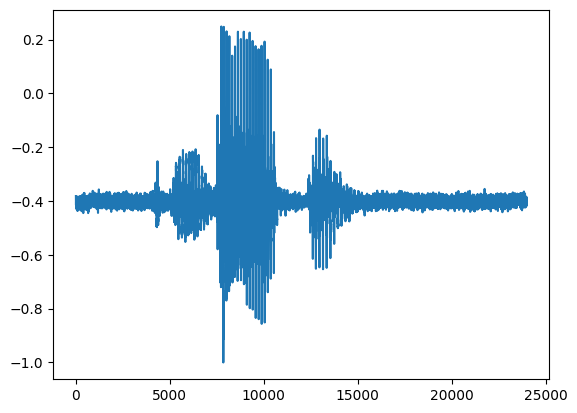

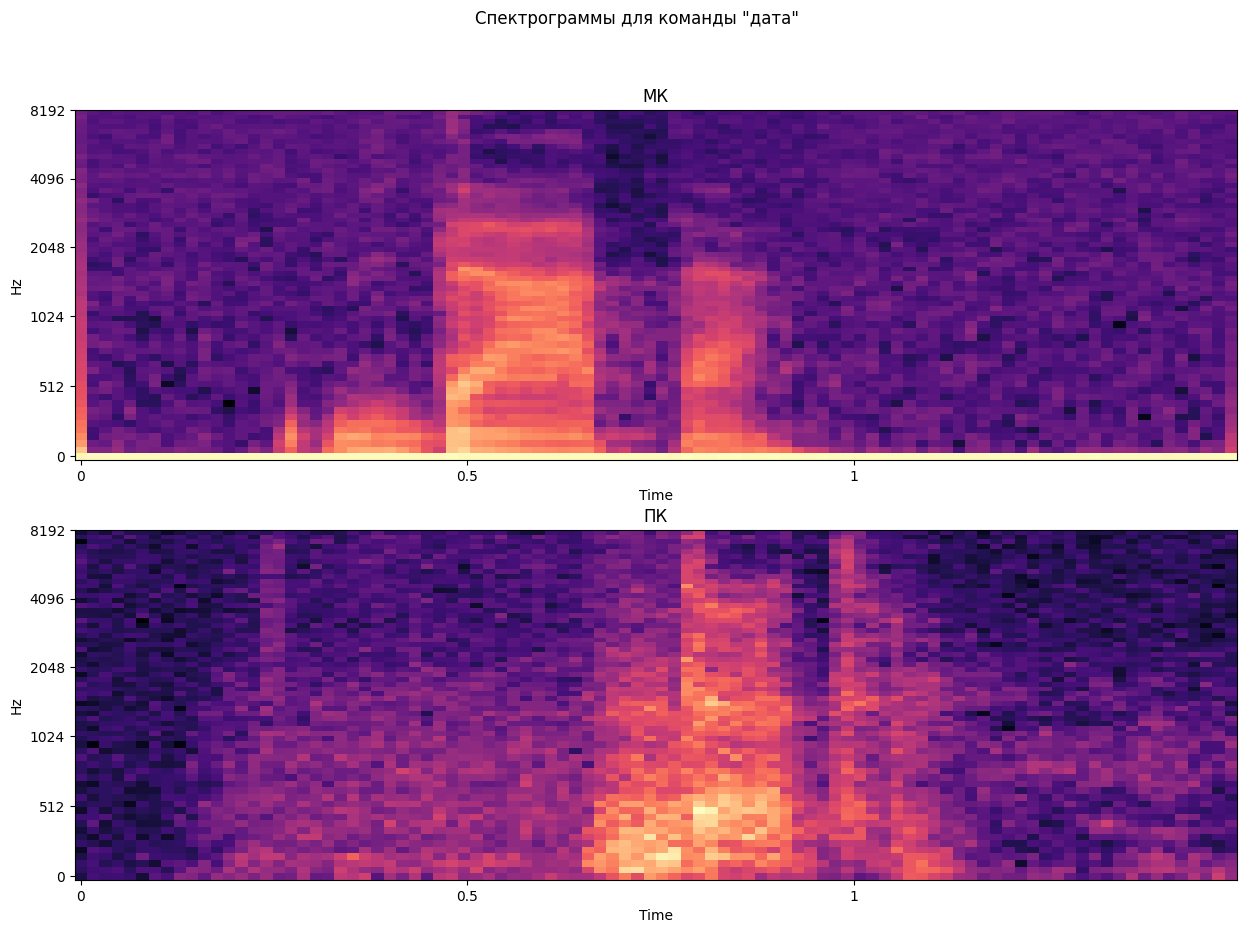

In [7]:
from fill_data import *
f = open('d7','rb')
spec = f.read()
array = np.frombuffer(spec, dtype=np.int16)
array = array.astype(np.float32)
array = librosa.util.normalize(array)
plt.plot(array)
array = create_mel_spec(array)
array = normalize(array)
fig, ax = plt.subplots(2, 1, figsize = (15, 10))
ax[0].set_title('МК')
ax[1].set_title('ПК')
fig.suptitle('Спектрограммы для команды "дата"')
librosa.display.specshow(array, 
                         sr=SAMPLE_RATE,
                         hop_length=HOP_LEN,
                         x_axis='time',
                         y_axis='mel',
                        ax = ax[0])
audio = X[1801]
print(classes[y[1800]])
noise = np.random.normal(0, 0.09, audio.shape)
audio_noisy = normalize(audio + noise)
print(audio.min())
print(array.mean() - audio_noisy.mean())
librosa.display.specshow(audio, 
                         sr=SAMPLE_RATE,
                         hop_length=HOP_LEN,
                         x_axis='time',
                         y_axis='mel',
                        ax = ax[1])
array += noise

In [121]:
array.mean()

np.float32(-40.31898)

In [44]:
normalize(create_mel_spec(get_signal())).mean()


Запись началась...
Запись завершена!


np.float32(0.25622255)

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet18
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pickle
import os
from sklearn.model_selection import train_test_split
model = ResNetSpectrogram(num_classes=4)
model.load_state_dict(torch.load('best_model.pth'))
model.eval()
from fill_data import *
#spec = normalize(create_mel_spec(get_signal()))
spec_tensor = torch.FloatTensor(array).unsqueeze(0).unsqueeze(0)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
input_data = spec_tensor.to(device)
with torch.no_grad():
    outputs = model(input_data)
    _, predicted = torch.max(outputs, 1)
    class_idx = predicted.item()

classes[class_idx]

C:\Users\KIRIL\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\KIRIL\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


'дата'

In [5]:
class ResNetSpectrogram(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.resnet = resnet18(pretrained=False)
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=1, padding=1, bias=False)
        self.resnet.avgpool = nn.Identity()
        self.resnet.fc = nn.Identity()
        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)
    
    def forward(self, x):
        
        x = self.resnet.conv1(x)
        x = self.resnet.bn1(x)
        x = self.resnet.relu(x)
        x = self.resnet.maxpool(x)
        #print(x.shape)
        
        x = self.resnet.layer1(x)
        x = self.resnet.layer2(x)
        x = self.resnet.layer3(x)
        x = self.resnet.layer4(x)
        #print(x.shape)
        
        x = self.adaptive_pool(x)
        #print(x.shape)
        
        x = torch.flatten(x, 1)
        #print(x.shape)

        x = self.fc(x)
        #print(x.shape)
        return x

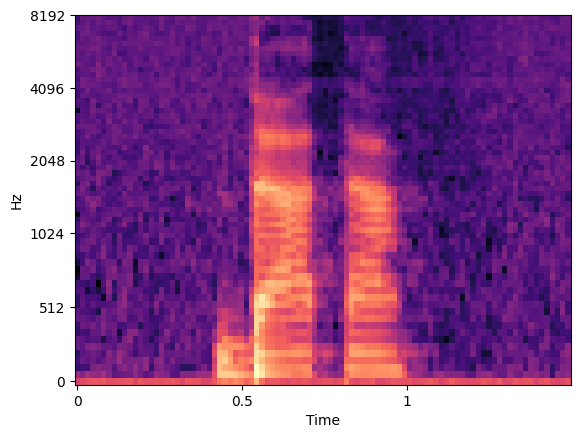

In [5]:
import pickle
import numpy as np
from fill_data import * 

f = open('./data_to_transform/raw/дата/audio_1749037067.pkl', 'rb')
data = f.read()
data = np.frombuffer(data, dtype = np.int16)
data = data.astype(np.float32)
spec = normalize(create_mel_spec(data)
f.close()
librosa.display.specshow(spec, 
                         sr=SAMPLE_RATE,
                         hop_length=HOP_LEN,
                         x_axis='time',
                         y_axis='mel')


In [10]:
import pickle
import numpy as np
from fill_data import * 


import os
import pickle

classes = ['алгоритмы', 'дата', 'время']
k = 0
if True:
    for c in classes:
        for filename in os.listdir('./data_to_transform/raw/' + c):
            filepath = os.path.join('./data_to_transform/raw/' + c, filename)
            #print(filepath[:len(directory + c)])
            print(filepath)
            f = open(filepath, 'rb')
            data = f.read()
            data = np.frombuffer(data, dtype = np.int16)
            data = data.astype(np.float32)
            data = librosa.util.normalize(data)
            spec = normalize(create_mel_spec(data))
            f.close()
            f = open('./data/' + 'norm/' + c + f'/mk{k}.pkl', 'wb')
            pickle.dump(spec, f)
            k += 1
            f.close()
        


./data_to_transform/raw/алгоритмы\audio_1749038157.pkl
./data_to_transform/raw/алгоритмы\audio_1749038164.pkl
./data_to_transform/raw/алгоритмы\audio_1749038171.pkl
./data_to_transform/raw/алгоритмы\audio_1749038178.pkl
./data_to_transform/raw/алгоритмы\audio_1749038185.pkl
./data_to_transform/raw/алгоритмы\audio_1749038193.pkl
./data_to_transform/raw/алгоритмы\audio_1749038200.pkl
./data_to_transform/raw/алгоритмы\audio_1749038207.pkl
./data_to_transform/raw/алгоритмы\audio_1749038213.pkl
./data_to_transform/raw/алгоритмы\audio_1749038221.pkl
./data_to_transform/raw/алгоритмы\audio_1749038228.pkl
./data_to_transform/raw/алгоритмы\audio_1749038234.pkl
./data_to_transform/raw/алгоритмы\audio_1749038244.pkl
./data_to_transform/raw/алгоритмы\audio_1749038251.pkl
./data_to_transform/raw/алгоритмы\audio_1749038258.pkl
./data_to_transform/raw/алгоритмы\audio_1749038266.pkl
./data_to_transform/raw/алгоритмы\audio_1749038273.pkl
./data_to_transform/raw/алгоритмы\audio_1749038279.pkl
./data_to_